<a href="https://colab.research.google.com/github/anilaq/capstone/blob/master/Copy_of_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install surprise

In [0]:
import pandas as pd 

import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds 

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline

from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD

from surprise.similarities import cosine, msd, pearson

from surprise import accuracy 
from surprise import Reader
from surprise import Dataset
from surprise import dataset



# Preprocessing

In [0]:
anime_df = pd.read_csv('./anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [0]:
anime_df.shape

(12294, 7)

In [0]:
anime_df.dropna(inplace=True)

In [0]:
anime_df.shape

(12017, 7)

## What each column represents: 
***anime_id: id number for each anime title***<br>
***name:  title of the motion picture***<br>
***genre:  category***<br>
***type:  describes the anime into tv, movies, OVA, and 3 other categories***<br>
***episodes: total number of episodes ***<br>
***rating: -1-10, lowest to highest*** <br>
***members:  number of community members that are in this anime group***<br>

In [0]:
anime_df.info() #having a look at all of the columns and types from the above cell and current to remove 
#any unneccessary extraneous data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


In [0]:
rating_df = pd.read_csv('./rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## What each column represents: 
*** user_id: non-identifiable randomly generated user id*** <br>
*** anime_id: the anime that the user has rated *** <br>
*** rating: rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating) ***

In [0]:
rating_df.shape

(7813737, 3)

Need to join both datasets together, will join using anime_id then hopefully will reshuffle the dataset so that it can be transformed into something that is compatible with `surprise`. 

I will join the two dataframes by merging them so that they can correspond to the correct anime_ids

In [0]:
df_merge = pd.merge(anime_df, rating_df, on = 'anime_id')
df_merge.head()
# df_merge = df_row.merge(rating_df, left_on= 'anime_id', how='outer')
# df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [0]:
df_merge.shape 

(7813611, 9)

*** The data here is extremely large. Because I will be using Singular Value Decomposition (SVD) which is known to be computationally expensive I will be taking a large sample from the 7.8 million rows. Before taking a sample I will remove the -1 ratings from the dataset since these don't really count as reviews ***

In [0]:
df_merge.rating_x.min()

1.67

In [0]:
df_merge = df_merge[df_merge.rating_y != -1]
df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10


In [0]:
df_merge.shape #have removed over 1 million rows

(6337146, 9)

In [0]:
sample = df_merge.sample(frac=.25)
sample.shape # this is still too large

(1584286, 9)

In [0]:
sample = df_merge.sample(n=5000)
sample.shape 

(5000, 9)

### IT SEEMS THAT THE RATING DF IS BASED ON EACH USER AND THEIR INDIVIDUAL RATING FOR EACH ANIME ID, WHEREAS THE ANIME DF IS AN AVERAGE OVERALL RATING FROM ALL OF ITS VIEWERS

In [0]:
#we are going to look at how many times each rating appears in a column
ratings_x = sample['rating_x'].value_counts() #continuous 
ratings_y = sample['rating_y'].value_counts() #discrete

print(ratings_x)
print(ratings_y)

7.81    65
8.06    62
8.17    60
7.88    55
7.57    53
        ..
5.13     1
4.65     1
4.80     1
4.72     1
6.20     1
Name: rating_x, Length: 321, dtype: int64
8     1285
7     1130
9     1027
10     738
6      454
5      221
4       91
3       29
1       14
2       11
Name: rating_y, dtype: int64


## Distribution of User Ratings

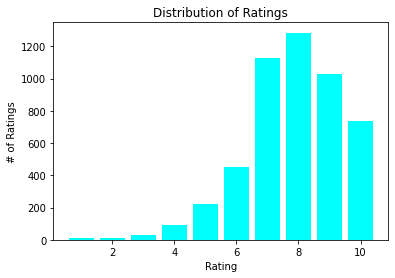

In [0]:
# plot distribution in matplotlib
ratings_sorted = sorted(list(zip(ratings_y.index, ratings_y)))
plt.bar([r[0] for r in ratings_sorted], [r[1] for r in ratings_sorted], color='cyan')
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

In [0]:
#number of users
print("Number of Users:", df_merge.user_id.nunique())
# print("Average Number of Reviews per User:", df_merge.shape[0])/df_merge.user_id.nunique()
avg_rate_peruser = df_merge.shape[0]
user = df_merge.user_id.nunique()
avg_num_review_per_user = avg_rate_peruser/user
print("Average Number of Reveiws per User:", avg_num_review_per_user)

Number of Users: 69600
Average Number of Reveiws per User: 91.05094827586207


In [0]:
sample['user_id'].value_counts()

21640    5
10989    4
47652    4
60291    4
58285    4
        ..
530      1
36067    1
34018    1
3295     1
57344    1
Name: user_id, Length: 4510, dtype: int64

## Number of Reviews per User

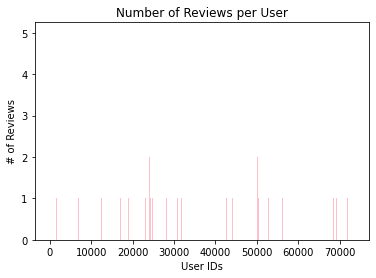

In [0]:
ratings_per_user = sample['user_id'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user], color='pink')
plt.xlabel('User IDs')
plt.ylabel('# of Reviews')
plt.title('Number of Reviews per User')
plt.show()

In [0]:
#graph on user ratings, what are the most common scores given 

## Different types of anime videos

In [0]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different anime:", sample.type.nunique())
print("Types of type:", sample.type.value_counts())

Number of users: 4510
Number of types of different anime: 6
Types of type: TV         3460
Movie       627
OVA         493
Special     360
ONA          47
Music        13
Name: type, dtype: int64


This means that there are six different categories for anime: <br>
Movies, TV, OVA, Special, ONA and Music. <br>
***OVA stands for orginal animation video, this has been released directly to the video market <br>
Special is not a common occuring video, it is usually shot yearly or on a one off <br>
Music is not just audio here, but a lively animated motion picture to go with the composed music piece ***

In [0]:
sample_of_sample = sample[:100] #taking a sample to see if its the amount of data or its the command given
sample_of_sample

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
6753809,9063,Toaru Kagaku no Railgun: Entenka no Satsuei Mo...,"Comedy, Ecchi",OVA,1,6.93,23004,21208,9
6256452,1225,3x3 Eyes Seima Densetsu,"Action, Adventure, Demons, Fantasy, Horror, Ro...",OVA,3,7.13,8892,30597,6
5413347,9888,Shinryaku! Ika Musume Specials,Comedy,Special,2,7.37,14497,40084,6
1442670,7465,Eve no Jikan (Movie),"Sci-Fi, Slice of Life",Movie,1,8.26,66376,15476,10
1255720,10800,Chihayafuru,"Drama, Game, Josei, Slice of Life, Sports",TV,25,8.32,158561,12718,9
...,...,...,...,...,...,...,...,...,...
3299944,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,62285,8
2606030,12445,Tasogare Otome x Amnesia,"Horror, Mystery, Romance, School, Shounen, Sup...",TV,12,7.95,172367,57761,8
1584517,18679,Kill la Kill,"Action, Comedy, School, Super Power",TV,24,8.23,508118,69802,10
169332,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,25102,10


In [0]:
sample.loc[sample['type'] == 'Movie']

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
1442670,7465,Eve no Jikan (Movie),"Sci-Fi, Slice of Life",Movie,1,8.26,66376,15476,10
4401884,17121,Dareka no Manazashi,"Drama, Slice of Life",Movie,1,7.57,28138,43068,5
6492163,1119,Pokemon: Celebi Toki wo Koeta Deai,"Adventure, Comedy, Drama, Fantasy, Kids",Movie,1,7.05,58359,50762,5
908858,2418,Stranger: Mukou Hadan,"Action, Adventure, Historical, Samurai",Movie,1,8.43,125503,23847,8
5602253,893,Dragon Ball Movie 4: Saikyou e no Michi,"Action, Adventure, Comedy, Fantasy, Sci-Fi, Sh...",Movie,1,7.33,26104,64623,7
...,...,...,...,...,...,...,...,...,...
3591985,430,Fullmetal Alchemist: The Conqueror of Shamballa,"Comedy, Drama, Fantasy, Historical, Military, ...",Movie,1,7.74,186465,19262,8
3472690,9745,Sengoku Basara Movie: The Last Party,"Action, Historical, Martial Arts, Samurai, Sup...",Movie,1,7.77,18267,26173,9
608603,3784,Evangelion: 2.0 You Can (Not) Advance,"Action, Mecha, Sci-Fi",Movie,1,8.53,182224,18366,10
3604594,9288,Heartcatch Precure! Movie: Hana no Miyako de F...,"Fantasy, Kids, Magic, Shoujo",Movie,1,7.74,3309,73247,8


In [0]:
len(sample.loc[sample['type'] == 'TV']) #How many tv shows there are in the dataframe

3460

In [0]:
len(sample.loc[sample['type'] == 'Movie'])

627

In [0]:
sample.loc[sample['type'] == 'Movie'].rating_x.value_counts() #Viewer ratings for films 

8.34    15
8.21    14
7.74    13
8.45    13
8.81    13
        ..
8.60     1
7.54     1
6.85     1
7.01     1
6.42     1
Name: rating_x, Length: 163, dtype: int64

In [0]:
sample.loc[sample['type'] == 'Movie'].rating_y.value_counts() #Viewer ratings for films 

8     164
7     138
9     133
10    111
6      40
5      23
4      11
3       6
1       1
Name: rating_y, dtype: int64

***drop rows containing -1 as rating in df_merge ***
could be that I have an approximation error 

*** Look at min ratings in rating_x *** if its a rating error, we would recreate y based off of x. (round to a whole number) *** 0 decimal places

## Most Reviewed Videos

In [0]:
movies_review = len(sample.loc[sample['type'] == 'Movie'])
movies_review

627

In [0]:
tv_reviews = len(sample.loc[sample['type'] == 'TV'])
tv_reviews

3460

In [0]:
ova_reviews = len(sample.loc[sample['type'] =='OVA'])
ova_reviews

493

In [0]:
music_reviews = len(sample.loc[sample['type'] =='Music'])
music_reviews

13

In [0]:
ona_reviews = len(sample.loc[sample['type'] =='ONA'])
ona_reviews

47

In [0]:
special_reviews = len(sample.loc[sample['type'] =='Special'])
special_reviews

360

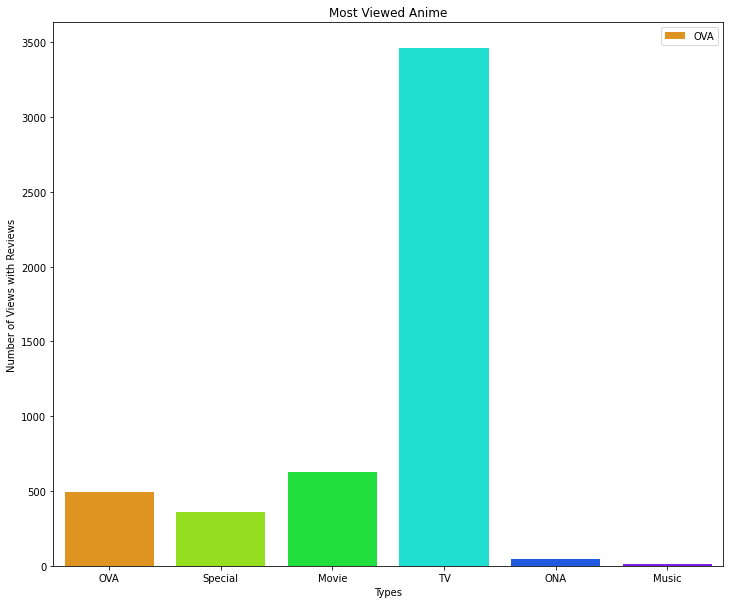

In [0]:
# PLOT them 
fig = plt.figure(figsize=(12,10))
sns.countplot(sample['type'], palette='gist_rainbow')
plt.title("Most Viewed Anime")
plt.xlabel("Types")
plt.ylabel("Number of Views with Reviews")
plt.legend(sample['type'])
plt.show()

# Long tailed 

In [0]:
len(sample)

5000

# Collaborative Models

In [0]:
class MyDataset(dataset.DatasetAutoFolds):
  #surprise.dataset.DatasetAutoFolds creates a surprise friendly dataset
  #this will give it folds so that cross validation can be performed efficiently
  def __init__(self, sample, reader):
    self.sample = [(uid, iid, r, None) for (uid, iid, r) in 
                   zip (sample['user_id'], sample['anime_id'], sample['rating_x'])]
    self.reader = reader

In [0]:
#instantiate the reader parser object
reader = Reader(line_format = 'user item rating', rating_scale = (0.0, 10.0))

In [0]:
#parse sample set into a surprise friendly dataset
data = MyDataset(sample, reader)

In [0]:
type(data)

__main__.MyDataset

# Implementing a Surprise's Singular Value Decomposition (SVD) as a Baseline

In [0]:
sample.rating_x = sample.rating_x.apply(round)
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
69465,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9,456749,11366,9
4498640,12679,Joshiraku,"Comedy, Slice of Life",TV,13,8,51084,56926,6
2055790,12113,Berserk: Ougon Jidai-hen II - Doldrey Kouryaku,"Action, Adventure, Demons, Drama, Fantasy, Hor...",Movie,1,8,66721,49399,9
818681,1698,Nodame Cantabile,"Comedy, Drama, Josei, Music, Romance, Slice of...",TV,23,8,157025,53782,10
3377399,8795,Panty &amp; Stocking with Garterbelt,"Action, Comedy, Ecchi, Parody, Supernatural",TV,13,8,157642,23088,9


In [0]:
#for surprise, it likes its data in a certain way and only that specific data
data = sample[['user_id', 'anime_id', 'rating_x']] #may need to do rating_x rounded and then use rating_y
reader = Reader(line_format='user item rating', sep='')
anime_data = Dataset.load_from_df(data, reader)
# anime_split = anime_data.split(n_folds=5) 

#train_test_split
trainset, testset = train_test_split(anime_data, test_size=.2)

In [0]:
anime_data

In [0]:
#INSTANTIATE the SVD and fit only the train set
svd = SVD()
svd.fit(trainset)

In [0]:
predictions = svd.test(testset) #
accuracy.rmse(predictions)

RMSE: 2.7568


2.756809750418044

In [0]:
predictions[:10]

[Prediction(uid=11256, iid=5116, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=29387, iid=530, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=47935, iid=8516, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=27016, iid=2129, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=6964, iid=232, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=45854, iid=11741, r_ui=9.0, est=5, details={'was_impossible': False}),
 Prediction(uid=843, iid=3457, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=39168, iid=8525, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=15222, iid=23775, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=40270, iid=7593, r_ui=7.0, est=5, details={'was_impossible': False})]

In [0]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different anime:", sample.type.nunique())


Number of users: 4513
Number of types of different anime: 6


In [0]:
user = 5
item = 100
svd.predict(user, item)

Prediction(uid=5, iid=100, r_ui=None, est=5, details={'was_impossible': False})

Now I need to compare the different models and see which ones perform best. I will stick to using RMSE to evaluate the models. I will also cross validate. 

In [0]:
#perform a gridsearch CV
params = {'n_factors': [20,50,100],
         'reg_all': [.02,.05, .10]}
gridsearch_svd1 = GridSearchCV(SVD, param_grid=params, n_jobs=-1, joblib_verbose=3)
gridsearch_svd1.fit(anime_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.5s finished


In [0]:
print(gridsearch_svd1.best_score)
print(gridsearch_svd1.best_params)

{'rmse': 2.7709600714967677, 'mae': 2.6758}
{'rmse': {'n_factors': 20, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


In [0]:
anime_data

## Cross Validation with K-Nearest Neighbors (KNN) Basic Algorithm

In [0]:
#cross validate with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=True)
cv_knn_basic = cross_validate(knn_basic, anime_data, n_jobs=2)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([2.8137164 , 2.77182251, 2.75426941, 2.73843021, 2.77632851]))
('test_mae', array([2.715, 2.675, 2.658, 2.643, 2.688]))
('fit_time', (1.2801885604858398, 1.3382289409637451, 1.1848986148834229, 1.2280447483062744, 0.6102993488311768))
('test_time', (0.012985944747924805, 0.013496160507202148, 0.012759685516357422, 0.01262354850769043, 0.007449150085449219))
-----------------
2.7709134079892577


In [0]:
knn_basic_msd = KNNBasic(sim_options = {'name': 'msd', 'user-based':True})
cv_knn_basic_msd = cross_validate(knn_basic_msd, anime_data, n_jobs=2)

In [0]:
for i in cv_knn_basic_msd.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_basic_msd['test_rmse']))

('test_rmse', array([2.75063629, 2.77146171, 2.77380605, 2.77524774, 2.78388218]))
('test_mae', array([2.656, 2.677, 2.684, 2.68 , 2.682]))
('fit_time', (0.7876389026641846, 0.9374661445617676, 0.7619931697845459, 0.7772557735443115, 0.5742416381835938))
('test_time', (0.012465476989746094, 0.012426376342773438, 0.012598276138305664, 0.012742996215820312, 0.0075604915618896484))
-----------------
2.771006793156371


## Cross Validation with KNN Baseline

In [0]:
#cross validate with KNN Baseline (pearson)
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, anime_data, n_jobs=3)

In [0]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([2.78944439, 2.77704879, 2.78729259, 2.73769976, 2.76333132]))
('test_mae', array([2.695, 2.682, 2.685, 2.649, 2.668]))
('fit_time', (1.1122894287109375, 1.7701339721679688, 2.4048147201538086, 1.527421236038208, 1.0526516437530518))
('test_time', (0.012477636337280273, 0.012503623962402344, 0.007084846496582031, 0.01253056526184082, 0.012827634811401367))
-----------------
2.7709633725629033


In [0]:
knn_baseline_msd = KNNBaseline(sim_options = {'name': 'msd', 'user_based': True})
cv_knn_baseline_msd = cross_validate(knn_baseline_msd, anime_data, n_jobs =2)

In [0]:
for i in cv_knn_baseline_msd.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_baseline_msd['test_rmse']))

('test_rmse', array([2.75826032, 2.77362579, 2.78082722, 2.75081806, 2.79141541]))
('test_mae', array([2.662, 2.683, 2.683, 2.655, 2.696]))
('fit_time', (0.7724204063415527, 0.8801229000091553, 0.9400205612182617, 0.862962007522583, 0.4758341312408447))
('test_time', (0.011576414108276367, 0.021898269653320312, 0.011184453964233398, 0.011204719543457031, 0.00687408447265625))
-------------------
2.7709893587857377


## Cross Validate with KNNBaseline using pearson baseline

In [0]:
knn_pearson_baseline = KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based':True})
cv_knn_pearson_baseline = cross_validate(knn_pearson_baseline, anime_data, n_jobs=3)

In [0]:
for i in cv_knn_pearson_baseline.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_pearson_baseline['test_rmse']))

('test_rmse', array([2.78280434, 2.7491817 , 2.80374749, 2.73495887, 2.78388218]))
('test_mae', array([2.686, 2.65 , 2.707, 2.646, 2.69 ]))
('fit_time', (1.297886848449707, 1.7786903381347656, 1.4173974990844727, 1.180288553237915, 0.7376847267150879))
('test_time', (0.028166770935058594, 0.02581930160522461, 0.011344194412231445, 0.01147150993347168, 0.007324695587158203))
-------------------
2.770914915445615


## KNN with Means 

In [0]:
knn_means = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
cv_knn_means = cross_validate(knn_means, anime_data, n_jobs=3)

In [0]:
for i in cv_knn_means.items():
  print(i)
print('------------')
print(np.mean(cv_knn_means['test_rmse']))

('test_rmse', array([2.77128129, 2.7871132 , 2.79231087, 2.74899982, 2.75517695]))
('test_mae', array([2.68 , 2.692, 2.705, 2.651, 2.651]))
('fit_time', (2.6919708251953125, 2.0485968589782715, 2.081186056137085, 1.2423324584960938, 0.9247946739196777))
('test_time', (0.02868175506591797, 0.022418498992919922, 0.035513877868652344, 0.013719320297241211, 0.0073430538177490234))
------------
2.7709764256700664


In [0]:
knn_means_msd = KNNWithMeans(sim_options={'name': 'msd', 'user_based':True})
cv_knn_means_msd = cross_validate(knn_means_msd, anime_data, n_jobs = 2)

In [0]:
for i in cv_knn_means_msd.items():
  print(i)
print('-------------')
print(np.mean(cv_knn_means_msd['test_rmse']))

('test_rmse', array([2.79624749, 2.76586334, 2.76242647, 2.77073997, 2.75971013]))
('test_mae', array([2.703, 2.664, 2.669, 2.675, 2.668]))
('fit_time', (0.7732229232788086, 0.9584963321685791, 0.9850521087646484, 0.8707234859466553, 0.509680986404419))
('test_time', (0.012360572814941406, 0.012421131134033203, 0.014667034149169922, 0.013013124465942383, 0.007328987121582031))
-------------
2.770997479067632


## Tuning the Best Algorithm with GridSearchCV
Best model so far is KNN Baseline with Mean Squared Distance

In [0]:
param_grid = {'n_factors': [5, 20, 100], 
              'n_epochs': [5,10], 
              'lr_all': [.002, .005], 
              'reg_all': [.02, .05, .5]}
knn_baseline_gs = GridSearchCV(KNNBaseline, param_grid=param_grid, n_jobs=3, joblib_verbose=3)
knn_baseline_gs.fit(anime_data)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   14.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   58.3s
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:  1.4min finished


In [0]:
print(knn_baseline_gs.best_score)
print(knn_baseline_gs.best_params)

{'rmse': 2.7709362805031312, 'mae': 2.6758}
{'rmse': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.02}, 'mae': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.02}}


In [0]:
#Now use this to fit test set, initial gridsearch was 2.77096, so will use that gs here
highest_perf_algo = gridsearch_svd1.best_estimator['rmse']

In [0]:
#retrain the whole set
trainset = anime_data.build_full_trainset()
highest_perf_algo.fit(trainset)

In [0]:
#Biased Accuracy on trainset
predictions = highest_perf_algo.test(trainset.build_testset())
print('Biased accuracy on Trainset', end='')
accuracy.rmse(predictions)

Biased accuracy on TrainsetRMSE: 2.7710


2.771028689855087

In [0]:
#UnBiased Accuracy on testset
predictions = highest_perf_algo.test(testset)
print('Unbiased Accuracy on test', end='')
accuracy.rmse(predictions)

Unbiased Accuracy on testRMSE: 2.7568


2.756809750418044

# WILL NOT CONTINUE USING PYSPARK! JUST REMEMBERED THAT THE LEARNCO IS OUTDATED

# Pyspark 

In [0]:
!pip install pyspark

In [0]:
from pyspark.sql import SparkSession 

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [0]:
#instantiate SparkSession object 
spark = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [0]:
sample.to_csv('sample.csv', index='False')

In [0]:
#read in data into pyspark dataframe
sample = spark.read.csv('./sample.csv', header='true', inferSchema='true')

## Fitting the Alternating Least Squares Model

In [0]:
from pyspark.ml.tuning.TrainValidationSplit


ModuleNotFoundError: ignored

In [0]:
#TRAIN TEST SPLIT
trainset, testset = anime_data.randomSplit([.8, .2])

AttributeError: ignored

In [0]:
#Build a recommendation model using ALS on the training data
als = ALS(maxIter=5,
         rank=4, 
         regParam=.01, 
         userCol='user_id',
         itemCol='anime_id',
         ratingCol='rating',
         coldStartStrategy='drop')
#fit the ALS to training set
als_model = als.fit(trainset)

In [0]:
#Let's evaluate its performance, above with surprise we got an unrealistic RMSE of 2.75
#start wtih a regression evaluator
from pyspark.ml.evaluation import RegressionEvaluator 
#let's compute the ALS RMSE on the testset
predictions = als_model.transform(testset)
evaluator = RegressionEvaluator(metricName='rmse',
                               labelCol='rating',
                               predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print("Root Mean Square Error:", str(rmse))


## Cross Validation to find the optimal model 